## Problem
Build a Deep Learning classification model that takes the hierarchy into consideration.
Take any 4 categories from the dataset (100 images each) such that there is a hierarchical relationship between them for eg:

Animals
- Dog
- Cat

~~Flowers~~ Fruits
- ~~Rose~~ Grapes
- ~~Sunflower~~ Pear

Build a Classification model for the above 4 categories, such that the penalty of inter-category prediction is higher.

## Import stuff

In [1]:
import os
import numpy as np
import sys
from PIL import Image
import PIL.ImageOps

from matplotlib import pyplot as plt
import matplotlib.cm as cm
import random

import keras
from keras import layers as L
from keras import optimizers as opt
from keras.preprocessing.image import ImageDataGenerator

# for reproducibility
from numpy.random import seed
seed(41)
from tensorflow import set_random_seed
set_random_seed(41)

Using TensorFlow backend.


## Extract and save the image files (28x28) from .npy files

### Split the npy file and save images

In [ ]:
# used code from: https://github.com/C-Aniruddh/RapidDraw/blob/in-dev/processing/process_all.py


# this cell needed to run only once. After downloading the npy files

number_images = 100; # Number of images in each category
img_width, img_height = 28, 28


npy_dir = '../data_dump/'
out_dir = './data/'
npy_files = [f for f in os.listdir(npy_dir) if os.path.isfile(os.path.join(npy_dir, f))]
print('Available classes:')
print(npy_files)

categories = []

for x in npy_files:
    category_split = x.split('.')
    category = category_split[0]
    categories.append(category)
    
print('Data from following classes will be unpacked:')
print(categories)

for y in categories:
    if not os.path.exists(os.path.join(out_dir, y)):
        os.makedirs(os.path.join(out_dir, y))

index_cat = 0
for z in npy_files:
    print('Processing file', z)
    images = np.load(os.path.join(npy_dir, z))
    print('Saving in', categories[index_cat])
    number_imgs = range(0, number_images, 1)
    for a in number_imgs:
        print('\t Processing Image', a+1)
        file_name = '%s.jpg' % (a+1)
        file_path = os.path.join(out_dir, categories[index_cat], file_name)
        img = images[a].reshape(img_width, img_height)
        f_img = Image.fromarray(img)
        inverted_image = PIL.ImageOps.invert(f_img)
        inverted_image.save(file_path, 'JPEG')
    index_cat = index_cat + 1

### Have a look at few training images

In [ ]:
# randomly picks 4 images per class
r, c = 2, 2
for d in os.listdir(out_dir):
    print(d)
    fig, axs = plt.subplots(r, c)
    cnt = 1
    for i in range(r):
        for j in range(c):
            img = plt.imread(out_dir+d+'/'+str(random.randint(1, 100))+'.jpg')
            axs[i, j].imshow(img, cmap=cm.gray)
            axs[i, j].axis('off')
            cnt += 1
    plt.show()
    plt.close()

## Create and verify the data generator

I chose to use a neural network to build the classifier. The reason is two-fold:
- CNN based neural networks are historically proven to be very strong at image classification, identification tasks.
- The test is on Deep Learning! ;-)

So, My idea is to build a multi-task model. First it will try to classify images into $animal$ or $fruit$ classes and then it will further classify among the four classes ($dog$, $cat$, $grapes$, $pear$). 

In [2]:
# few constants
data_path = './data/'
val_data_path = './val_data/'
img_width, img_height, n_channel = 28, 28, 3
img_shape = (img_width, img_height)
batch_size = 32
epoch = 20

In [3]:
# create a generator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
train_generator = datagen.flow_from_directory(data_path, target_size=(img_width, img_height)
                    , class_mode='categorical'
                    , batch_size=batch_size, interpolation='nearest'
                    , shuffle=True
                   )
val_generator = ImageDataGenerator(
    rescale=1./255).flow_from_directory(val_data_path, target_size=(img_width, img_height)
                    , class_mode='categorical'
                    , batch_size=batch_size, interpolation='nearest'
                    , shuffle=True
                   )

Found 400 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [4]:
# mode will be train for both training and validation
def combined_generator(datagen, mode='train'):
    y_4c = None
    while True:
        if mode == 'train':
            X_batch, y_4c = datagen.next()
        else:
            X_batch = datagen.next()
        if y_4c is not None:
            # class and how the target looks for y_4c
            # cat     [1, 0, 0, 0]
            # dog     [0, 1, 0, 0]
            # grapes  [0, 0, 1, 0]
            # pear    [0, 0, 0, 1]

            # for a_vs_f model we need target of shape (batch_size, 2)
            # class cat and dog -> [1, 0]
            # class grapes and pear -> [0, 1]
            # how class and the target should look for a_vs_f model
            # cat     [1, 0]
            # dog     [1, 0]
            # grapes  [0, 1]
            # pear    [0, 1]

            y_a_f = np.zeros((y_4c.shape[0], 2))
            for idx, y in enumerate(y_4c):
                if np.all(y == [1, 0, 0, 0]) or np.all(y == [0, 1, 0, 0]):
                    y_a_f[idx] = [1, 0]
                else:
                    y_a_f[idx] = [0, 1]
            yield X_batch, [y_a_f, y_4c]
        else:
            yield X_batch
    

Shape of one batch of data:
X shape:  (32, 28, 28, 3)
y shape:  (32, 4)


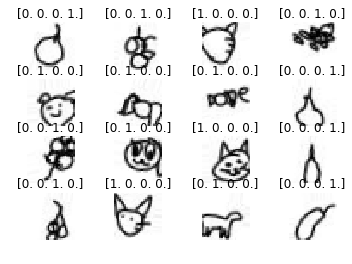

In [5]:
# test how my generator is doing
X, y = next(train_generator) # ask for a batch

print('Shape of one batch of data:')
print('X shape: ', X.shape)
print('y shape: ', y.shape)


r, c = 4, 4 # lets not show entire batch, check rxc images
imgs = X[:r*c]
labels = y[:r*c]
cnt = 0
fig, axs = plt.subplots(r, c)
for i in range(r):
    for j in range(c):
        img = imgs[cnt]
        axs[i, j].imshow(img, cmap=cm.gray)
        axs[i, j].axis('off')
        axs[i, j].set_title(str(labels[cnt]))
        cnt += 1
plt.show()
plt.close()


## Build models

In [6]:
# some model realted constants
latent_dim = 128
epochs = 50
num_a_f_update = 2

In [7]:
# build the animal vs fruit model
def build_a_vs_f_model(input_dim=(img_width, img_height, n_channel), n_classes=2):
    input_ = L.Input(shape=input_dim)
    x = L.Conv2D(32, kernel_size=(3, 3), activation='relu')(input_)
    x = L.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = L.MaxPooling2D(pool_size=(2, 2))(x)
    x = L.Dropout(0.25)(x)
    x = L.Flatten()(x)
    x = L.Dense(latent_dim, activation='relu')(x)
    feat = L.Dropout(0.5)(x)
    pred = L.Dense(n_classes, activation='softmax')(feat)
    # this is to classify animal vs fruit
    af_model = keras.models.Model(inputs=input_, outputs=pred, name='af_model')
    # idea is to use this layer output as a input feature to the 4 class classification problem
    af_feature_model = keras.models.Model(inputs=input_, outputs=feat, name='feat_model')
    
    af_model.summary()
    return af_model, af_feature_model

In [8]:
# build the 4 class classification model
def build_4class_model(input_dim=(img_width, img_height, n_channel), n_classes=4, latent_dim=128):
    input_img = L.Input(shape=input_dim)
    x = L.Conv2D(32, kernel_size=(3, 3), activation='relu')(input_img)
    x = L.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = L.MaxPooling2D(pool_size=(2, 2))(x)
    x = L.Dropout(0.25)(x)
    x = L.Flatten()(x)
    x = L.Dense(128, activation='relu')(x)
    
    input_feat = L.Input(shape=(latent_dim,))
    y = L.Concatenate()([x, input_feat])
    y = L.Dense(128)(y)
    y = L.Dropout(0.25)(y)
    y = L.Dense(64)(y)
    y = L.Dropout(0.25)(y)
    y = L.Dense(32)(y)
    y = L.Dropout(0.25)(y)
    pred = L.Dense(n_classes, activation='softmax')(y)
    model = keras.models.Model(inputs=[input_img, input_feat], outputs=pred, name='class4_model')
    model.summary()

    return model

In [9]:
def build_combined_model(a_vs_f_model, feat_model, class4_model):
    inputs = L.Input(shape=(img_width, img_height, n_channel))
    a_f = a_vs_f_model(inputs)
    feat = feat_model(inputs)
    pred = class4_model([inputs, feat])
    model = keras.models.Model(inputs=inputs, outputs=[a_f, pred], name='comb_model')
    model.summary()
    return model

In [10]:
# now, time to train the model
def train_model():
    
    # create models
    a_vs_f_model, feat_model = build_a_vs_f_model()
    class_4_model = build_4class_model()
    combined_model = build_combined_model(a_vs_f_model, feat_model, class_4_model)
    
    # get opt
    comb_opt = opt.Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    loss_weights = [2, 1]
    combined_model.compile(optimizer=comb_opt
                           , loss=['categorical_crossentropy', 'categorical_crossentropy']
                           , loss_weights=loss_weights, metrics=['acc'])
    
    # set up callbacks
    model_filepath = 'model.hdf5'
    chkpoint = keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_loss', verbose=1
                    , save_best_only=True, save_weights_only=False, mode='auto', period=1)
    callback_list=[keras.callbacks.History(), chkpoint]
    
    history = combined_model.fit_generator(
            generator=combined_generator(train_generator),
            steps_per_epoch=1+train_generator.n//train_generator.batch_size,
            validation_data=combined_generator(val_generator),
            validation_steps=1+val_generator.n//val_generator.batch_size,
            callbacks=callback_list,
            epochs=epochs
        )
        
    return combined_model, history
    

In [11]:
combined_model, history = train_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)  


Epoch 00002: val_loss improved from 2.67161 to 2.55953, saving model to model.hdf5
Epoch 3/50
13/13 [==============================] - 4s 279ms/step - loss: 2.7081 - af_model_loss: 0.6839 - class4_model_loss: 1.3403 - af_model_acc: 0.5606 - class4_model_acc: 0.3175 - val_loss: 2.4630 - val_af_model_loss: 0.6343 - val_class4_model_loss: 1.1945 - val_af_model_acc: 0.6700 - val_class4_model_acc: 0.6525

Epoch 00003: val_loss improved from 2.55953 to 2.46303, saving model to model.hdf5
Epoch 4/50
13/13 [==============================] - 4s 278ms/step - loss: 2.6420 - af_model_loss: 0.6614 - class4_model_loss: 1.3191 - af_model_acc: 0.6532 - class4_model_acc: 0.3937 - val_loss: 2.3642 - val_af_model_loss: 0.5950 - val_class4_model_loss: 1.1741 - val_af_model_acc: 0.8275 - val_class4_model_acc: 0.4725

Epoch 00004: val_loss improved from 2.46303 to 2.36420, saving model to model.hdf5
Epoch 5/50
13/13 [==============================] - 4s 280ms/step - loss: 2.5690 - af_model_loss: 0.6556 - c

13/13 [==============================] - 4s 294ms/step - loss: 1.8641 - af_model_loss: 0.4690 - class4_model_loss: 0.9262 - af_model_acc: 0.7888 - class4_model_acc: 0.5846 - val_loss: 1.3838 - val_af_model_loss: 0.3443 - val_class4_model_loss: 0.6952 - val_af_model_acc: 0.8625 - val_class4_model_acc: 0.7300

Epoch 00023: val_loss improved from 1.38822 to 1.38377, saving model to model.hdf5
Epoch 24/50
13/13 [==============================] - 4s 285ms/step - loss: 1.9836 - af_model_loss: 0.5000 - class4_model_loss: 0.9837 - af_model_acc: 0.7600 - class4_model_acc: 0.5606 - val_loss: 1.4398 - val_af_model_loss: 0.3606 - val_class4_model_loss: 0.7186 - val_af_model_acc: 0.8500 - val_class4_model_acc: 0.6975

Epoch 00024: val_loss did not improve from 1.38377
Epoch 25/50
13/13 [==============================] - 4s 281ms/step - loss: 1.9442 - af_model_loss: 0.5127 - class4_model_loss: 0.9188 - af_model_acc: 0.7763 - class4_model_acc: 0.5961 - val_loss: 1.3850 - val_af_model_loss: 0.3543 - v

13/13 [==============================] - 4s 286ms/step - loss: 1.6155 - af_model_loss: 0.4030 - class4_model_loss: 0.8095 - af_model_acc: 0.8388 - class4_model_acc: 0.6612 - val_loss: 1.3094 - val_af_model_loss: 0.2977 - val_class4_model_loss: 0.7140 - val_af_model_acc: 0.8950 - val_class4_model_acc: 0.7325

Epoch 00044: val_loss did not improve from 1.21111
Epoch 45/50
13/13 [==============================] - 4s 278ms/step - loss: 1.6268 - af_model_loss: 0.3995 - class4_model_loss: 0.8279 - af_model_acc: 0.8531 - class4_model_acc: 0.6324 - val_loss: 1.3022 - val_af_model_loss: 0.2890 - val_class4_model_loss: 0.7241 - val_af_model_acc: 0.8925 - val_class4_model_acc: 0.7225

Epoch 00045: val_loss did not improve from 1.21111
Epoch 46/50
13/13 [==============================] - 4s 275ms/step - loss: 1.6405 - af_model_loss: 0.4083 - class4_model_loss: 0.8240 - af_model_acc: 0.8290 - class4_model_acc: 0.6465 - val_loss: 1.3102 - val_af_model_loss: 0.2872 - val_class4_model_loss: 0.7358 - v

In [12]:
# lets have a look at the loss and acc of the model for train and val dataset
def plot_model_perf(history):
    # keys are hard to remmeber
    print(history.history.keys())
    
    # summarize history for different accuracies
    plt.plot(history.history['af_model_acc'])
    plt.plot(history.history['val_af_model_acc'])
    plt.title('animal vs fruit model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(history.history['class4_model_acc'])
    plt.plot(history.history['val_class4_model_acc'])
    plt.title('4 class model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # summarize history for losses
    plt.plot(history.history['af_model_loss'])
    plt.plot(history.history['val_af_model_loss'])
    plt.title('animal vs fruit model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['class4_model_loss'])
    plt.plot(history.history['val_class4_model_loss'])
    plt.title('4 class model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

dict_keys(['val_loss', 'val_af_model_loss', 'val_class4_model_loss', 'val_af_model_acc', 'val_class4_model_acc', 'loss', 'af_model_loss', 'class4_model_loss', 'af_model_acc', 'class4_model_acc'])


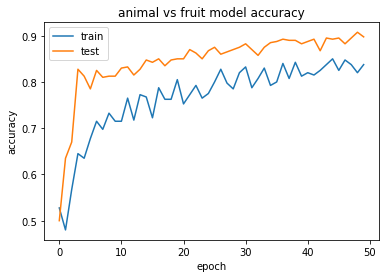

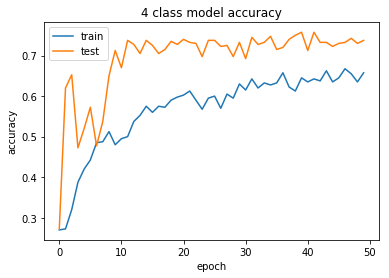

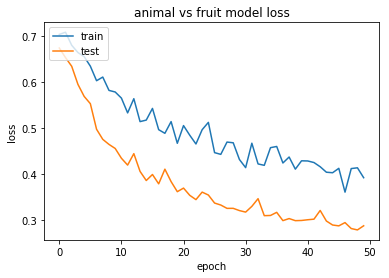

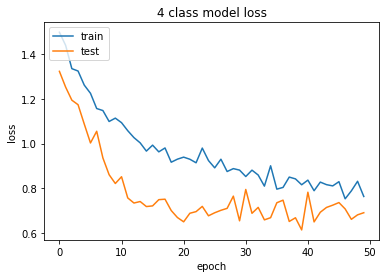

In [13]:
plot_model_perf(history)

### The end